## Boosting pair solution

### Part 1 - Implement Adaboost Classifier

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.ensemble import AdaBoostClassifier
from boosting_soln import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1) # consistent results
   
# path may need to be modified based on relative location of spam.csv
data = np.genfromtxt('../data/spam.csv', delimiter=',')
y = data[:, -1]
X = data[:, 0:-1]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [3]:
my_ada = AdaBoostBinaryClassifier(n_estimators=50)
my_ada.fit(X_train, y_train)

abc = AdaBoostClassifier(n_estimators=50)
abc.fit(X_train, y_train)

print("\nPart 1 - Implementing your own AdaBoostClassifier")
print("-" * 50)
print(" Custom ABC accuracy: {0:0.3f}".format(my_ada.score(X_test, y_test)))
print("sklearn ABC accuracy: {0:0.3f}".format(abc.score(X_test, y_test)))


Part 1 - Implementing your own AdaBoostClassifier
--------------------------------------------------
 Custom ABC accuracy: 0.933
sklearn ABC accuracy: 0.947


### Part 2 - Estimator Complexity

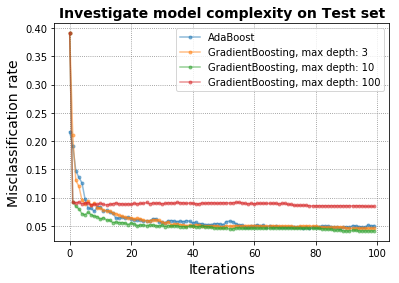

In [4]:
n_trees = 100 
models = [AdaBoostClassifier(n_estimators=n_trees),
          GradientBoostingClassifier(n_estimators=n_trees),
          GradientBoostingClassifier(n_estimators=n_trees, max_depth = 10),
          GradientBoostingClassifier(n_estimators=n_trees, max_depth = 100)
          ]
for model in models: 
    stage_score_plot(model, X_train, X_test, y_train, y_test)
plt.legend()
plt.title('Investigate model complexity on Test set', fontsize=14, fontweight='bold')
plt.grid(color='grey', linestyle='dotted') 

In [5]:
answer_description_2_3()

3) The Gradient Boosting Classifier that allows for its trees to be 100
splits deep doesn't perform well with increased iterations (boosts).
This is expected as boosting helps decrease bias over time, but the
100 split deep classifier starts with relatively low bias, so boosting
it will have less effect than it has on the less deep classifiers.  In
the end, boosting enables the ensemble based on less complex models to
outperform the boosted, more complex model.


#### Grid search - coarse first, then fine

In [6]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')  # annoying warnings

In [7]:
model_best = grid_search(X_train, y_train)


4) Part 2 grid search
Starting grid search - coarse (will take several minutes)
Coarse search best parameters:
learning_rate        | 0.1
max_depth            | 10
max_features         | sqrt
min_samples_leaf     | 10
n_estimators         | 100
random_state         | 1
subsample            | 1.0
Coarse search best score: 0.953

Starting grid search - fine
Fine search best parameters:
learning_rate        | 0.05
max_depth            | 10
max_features         | sqrt
min_samples_leaf     | 2
n_estimators         | 100
random_state         | 1
subsample            | 1.0
Fine search best score: 0.950
Returning best model.


In [8]:
y_pred = model_best.predict(X_test)
mc_rate = misclassification_rate(y_pred, y_test)
print("4) The misclassification rate is {0:0.3f}".format(mc_rate))

4) The misclassification rate is 0.036


### Part 3 - Feature importance and partial dependency plots

In [9]:
import requests
import itertools
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from mpl_toolkits.mplot3d import Axes3D

In [10]:
feature_importances = model_best.feature_importances_
top10_colindex = np.argsort(feature_importances)[::-1][0:10]
feature_importances = feature_importances[top10_colindex]
feature_importances = feature_importances / float(feature_importances.max()) #normalize

In [11]:
all_feature_names = get_feature_names()
feature_names = list(all_feature_names[top10_colindex])

In [12]:
print("1) Sorted features, their relative importances, and their indices:" )
for fn, fi, indx in zip(feature_names, feature_importances, top10_colindex):
    print("{0:<30s} | {1:6.3f} | {2}".format(fn, fi, indx))

1) Sorted features, their relative importances, and their indices:
char_freq_!                    |  1.000 | 51
capital_run_length_longest     |  0.683 | 55
char_freq_$                    |  0.653 | 52
capital_run_length_average     |  0.650 | 54
word_freq_remove               |  0.600 | 6
word_freq_free                 |  0.595 | 15
capital_run_length_total       |  0.584 | 56
word_freq_you                  |  0.566 | 18
word_freq_your                 |  0.475 | 20
word_freq_hp                   |  0.474 | 24


### 1) Feature importance bar plot

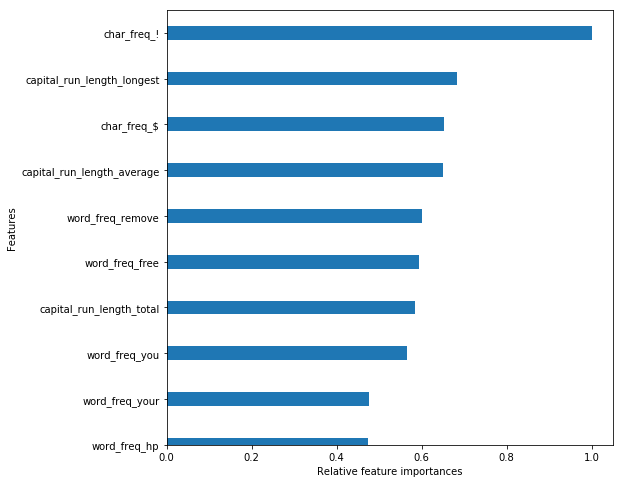

In [13]:
y_ind = np.arange(9, -1, -1) # 9 to 0
fig = plt.figure(figsize=(8, 8))
plt.barh(y_ind, feature_importances, height = 0.3, align='center')
plt.ylim(y_ind.min() + 0.5, y_ind.max() + 0.5)
plt.yticks(y_ind, feature_names)
plt.xlabel('Relative feature importances')
plt.ylabel('Features');

### 2) Partial dependency plots

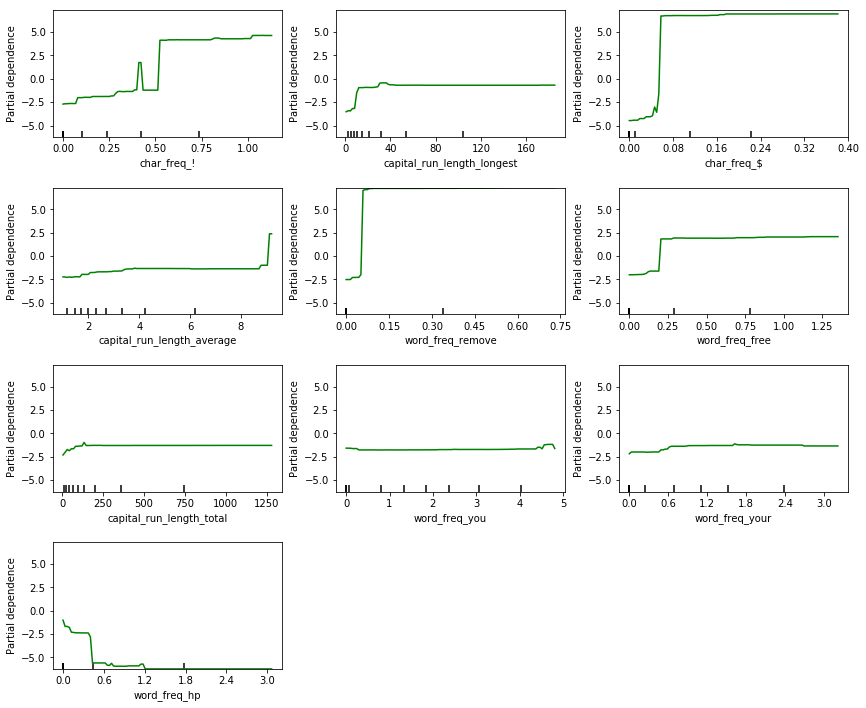

In [14]:
plot_partial_dependence(model, X_train, top10_colindex,
                        feature_names = all_feature_names,
                        figsize=(12,10))
plt.tight_layout();

In [15]:
answer_description_3_2()


2) Partial dependency plots show the effect of a given feature on
the target variable after accounting for the average effect of all
the other features.  The regions where the graph is flat means
that there isn't much of a relationship between the target (in
this case, whether it's spam or not) and the feature investigated
by that plot in that region.  However, in areas where it isn't flat
the target is more dependent on the feature in question.

As shown in the plots, as the 'char_freq_!' and 'char_freq_$'
feature values increase, the chance of spam (value 1) increases
This is also true for 'capital_run_length_total' for values <
about 125 characters, however after that it doesn't make much
difference.  The other plots can be interpreted in a similar way.


### 3) Examine partial dependence of two features on the target

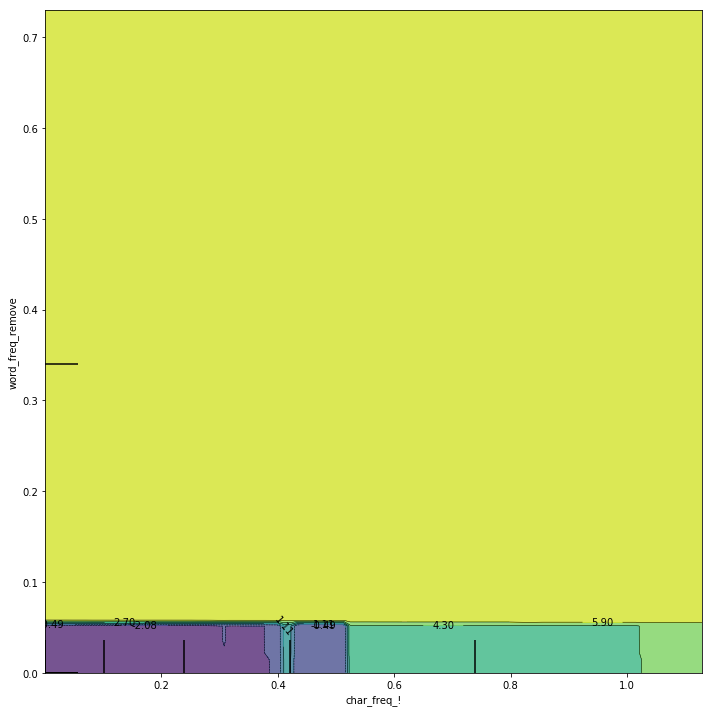

In [16]:
plot_partial_dependence(model, X_train, [(51, 6)],
                        feature_names = all_feature_names,
                        figsize=(10,10))
plt.tight_layout();

#### 3D partial dependency plot

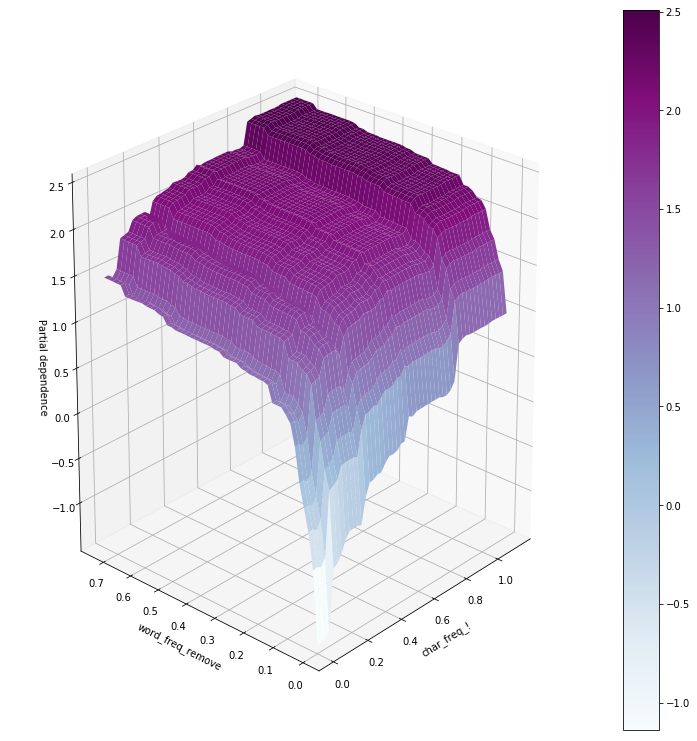

In [17]:
fig = plt.figure(figsize = (10, 10))
ax = Axes3D(fig)
target_feature = (51, 6) # indices of features to plot
pdp, (x_axis, y_axis) = partial_dependence(model_best, target_feature,
                                           X=X_train, grid_resolution=50)
XX, YY = np.meshgrid(x_axis, y_axis)
Z = pdp.T.reshape(XX.shape).T

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
ax.set_xlabel(all_feature_names[target_feature[0]])
ax.set_ylabel(all_feature_names[target_feature[1]])
ax.set_zlabel('Partial dependence')
ax.view_init(elev=22, azim=222)
plt.colorbar(surf)
plt.subplots_adjust(top=0.9)